In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
%matplotlib inline
import glob
 
import os
print("Running this from: ",os.getcwd())

Running this from:  /home/sundari/Documents/sdc/CarND-Advanced-Lane-Lines


<h3>Utility Functions

In [2]:
def visualize(orig_img,trans_img,text1='Original Image',text2='Transformed Image'):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(orig_img)
    ax1.set_title(text1, fontsize=15)
    ax2.imshow(trans_img, cmap='gray')
    ax2.set_title(text2, fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
images = glob.glob('./camera_cal/calibration*.jpg')
objpoints = []
imgpoints = []

objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

<h2>1. Camera Calibration & Distortion Correction</h2>

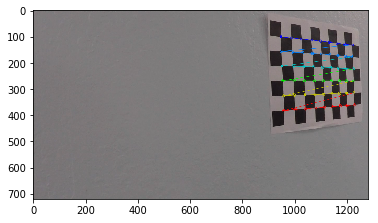

In [4]:
for img_ in images:
    img = cv2.imread(img_)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
    
    if ret == True:
        #print(corners.shape)
        #print(objp.shape)
        imgpoints.append(corners)
        objpoints.append(objp)
        
        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
        plt.imshow(img)
        
for img_ in images:
    
    img = cv2.imread(img_)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('./cal_corrected/'+img_[13:],dst)

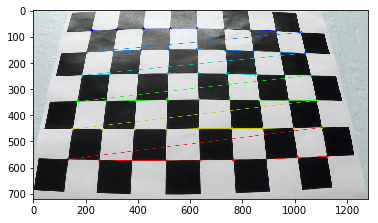

In [5]:
#Test on sample Image
img = cv2.imread('camera_cal/calibration3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)

    img_ = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    plt.imshow(img_)

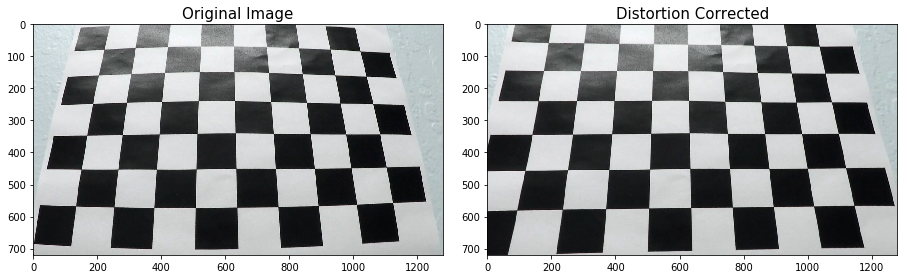

In [6]:
#Test on sample Image
img = cv2.imread('camera_cal/calibration3.jpg')
#Get mtx and dist parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undst = cv2.undistort(img, mtx, dist, None, mtx)

visualize(img,undst,text1='Original Image',text2='Distortion Corrected')


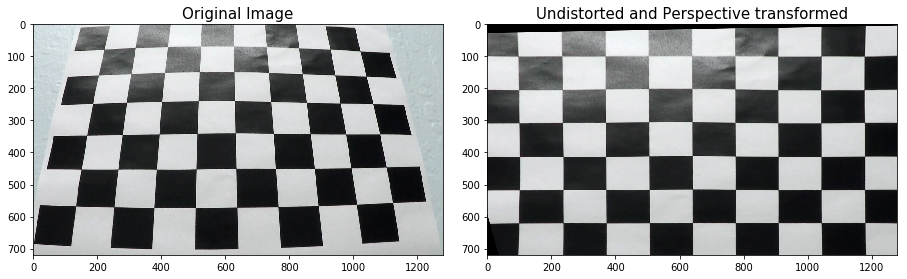

In [7]:
gray = cv2.cvtColor(undst, cv2.COLOR_BGR2GRAY)
x,y = 9,6
ret, corners = cv2.findChessboardCorners(gray, (x,y), None)

if ret == True:
    cv2.drawChessboardCorners(dst, (x,y), corners, ret)
    offset = 100
    img_size = (gray.shape[1], gray.shape[0])
    src = np.float32([corners[0],
                      corners[x-1],
                      corners[-1],
                      corners[-x]])
    dst = np.float32([[offset, offset],
                      [img_size[0]-offset, offset],
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undst, M, img_size)

visualize(img,warped,text1='Original Image',text2='Undistorted and Perspective transformed')

<h2>Essential Functions

In [8]:
class Line():
    
    def __init__(self):
        
        self.detected = False
        
        self.recent_xfits = []
        self.best_xfit = None
        
        self.current_fit_coeffs = [np.array([False])]
        self.best_fit_coeffs = None
                
        self.radius_of_curvature = None
        self.line_base_position = None
        
        self.allx = None
        self.ally = None
        
def verify_lane_width(left, right):
    print(left-right)
    if np.absolute(left - right) > 1100 | np.absolute(left - right) < 900:
        return True
    else:
        return False
    
def annotate(img, left_curverad, right_curverad, camera):
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.putText(img, 'Left Radius of Curvature: {0:6f} meters'.format(left_curverad), (10,30), font, 1, (255,255,255), 2)
    cv2.putText(img, 'Right Radius of Curvature: {0:6f} meters'.format(right_curverad),(10,60), font, 1, (255,255,255), 2)
    cv2.putText(img, 'Camera Offset: {0:6f} meters'.format(camera), (10,90), font, 1, (255,255,255), 2)


In [9]:
#Function Definitions
def undistort(img):
    #Mtx and dist are loaded earlier
    return cv2.undistort(img, mtx, dist, None, mtx)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(15, 150)):
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    thresh_min = thresh[0]
    thresh_max = thresh[1]

    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sbinary

def f_mag_thresh(img, sobel_kernel=15, mag_thresh=(50, 220)):
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.1)):
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def color_thresholds(img, HLS_s_threshold=(60, 255), HSV_v_threshold=(120,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > HLS_s_threshold[0]) & (s_channel <= HLS_s_threshold[1])] = 1
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > HSV_v_threshold[0]) & (v_channel <= HSV_v_threshold[1])] = 1  
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_binary == 1) & (v_binary == 1)] = 1
    return binary_output

def combined_thresholds(img):
    
    binary_x = abs_sobel_thresh(img,orient='x')
    binary_y = abs_sobel_thresh(img,orient='y')
    mag = f_mag_thresh(img)
    direct = dir_threshold(img)
    color = color_thresholds(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_output = np.zeros_like(img)
    #binary_output[color == 1] = 1
    binary_output[(binary_x == 1) & (binary_y == 1) & (mag == 1) | (color == 1) | (mag == 1) & (direct == 1)] = 1
    return binary_output

def region_of_interest_left(img):
    width = img.shape[1]
    height = img.shape[0]
    vertices = np.array([[(width*0.49, height*0.55),
                        (width*0.49, height*0.55),
                        (width*0.3, height),
                        (width*0.15, height)]], 
                        dtype=np.int32)
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image_left = cv2.bitwise_and(img, mask)
    return masked_image_left

def region_of_interest_right(img):
    width = img.shape[1]
    height = img.shape[0]
    vertices = np.array([[(width*0.51, height*0.55),
                        (width*0.51, height*0.55),
                        (width*0.95, height),
                        (width*0.8, height)]], 
                        dtype=np.int32)
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image_right = cv2.bitwise_and(img, mask)
    return masked_image_right

def region_of_interest(img):
    mask_left = region_of_interest_left(img)
    mask_right = region_of_interest_right(img)
    masked_image = cv2.addWeighted(mask_left, 1.0, mask_right, 1.0, 0)
    return masked_image

def transform_perspective(img):
    width = img.shape[1]
    height = img.shape[0]
    src = np.array([[(width*0.4, height*0.65),
                        (width*0.6, height*0.65),
                        (width, height),
                        (0, height)]], 
                        dtype=np.float32)
    dst = np.array([[0,0], 
                    [img.shape[1], 0], 
                    [img.shape[1], img.shape[0]],
                    [0, img.shape[0]]],
                    dtype = 'float32')
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_output = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped_output, M, Minv


LEFT = Line()
RIGHT = Line()
def sliding_windows(binary_warped):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 50
    minpix = 1
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 255, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 0]
    
    #For Video:
    LEFT.recent_xfits = [(left_fitx)]
    LEFT.best_xfit = np.mean(LEFT.recent_xfits)
    RIGHT.recent_xfits = [(right_fitx)]
    RIGHT.best_xfit = np.mean(RIGHT.recent_xfits)
        
    LEFT.current_fit_coeffs = [(left_fit)]
    LEFT.best_fit_coeffs = np.mean(LEFT.current_fit_coeffs)
    RIGHT.current_fit_coeffs = [(right_fit)]
    RIGHT.best_fit_coeffs = np.mean(RIGHT.current_fit_coeffs)
    
    LEFT.line_base_position = leftx_current
    RIGHT.line_base_position = rightx_current
    
    LEFT.allx = leftx
    LEFT.ally = lefty
    RIGHT.allx = rightx
    RIGHT.ally = righty
    
    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, rightx, leftx_base, rightx_base

def shaded_lanes(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    if left_fitx.all() != 0:
        LEFT.detected == True
    else:
        LEFT.detected == False
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    if right_fitx.all() != 0:
        RIGHT.detected == True
    else:
        RIGHT.detected == False
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit

def roc_in_pixels(ploty, left_fit, right_fit, leftx, rightx):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

def roc_in_meters(ploty, left_fit, right_fit, leftx, rightx):
    
    ym_per_pix = 30/550
    xm_per_pix = 3.5/1000
    y_eval = np.max(ploty)
    leftx = np.array(leftx, dtype=np.float32)
    rightx = np.array(rightx, dtype=np.float32)
    left_fit_cr = np.polyfit(leftx*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(rightx*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #For Video:
    
    LEFT.radius_of_curvature = left_curverad
    RIGHT.radius_of_curvature = right_curverad
    
    return left_curverad, right_curverad

def offset(img_center, leftx_base, rightx_base):
    poly_center = (leftx_base + rightx_base) / 2
    diff_pix = img_center - poly_center
    xm_per_pix = 3.5/1000
    offset = diff_pix * xm_per_pix
    return offset

def lane_mapping(img_shape, warped, Minv, ploty, left_fitx, right_fitx, undistorted):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0)) 
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_shape[1], img_shape[0])) 
    out_img = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return out_img

<h2>Pipeline Setup</h2>

In [10]:
def pipeline(op=None):
    
    test_images = glob.glob('test_images/test*.jpg')
    #print ('test_images ', len(test_images))
    n = 0
    for img in test_images:
        img = mpimg.imread(img)
        test_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        if op == 'Undistorted':
            img_undst = undistort(img)
            visualize(img,img_undst,text1='Original Image',text2='Transformed Image')
            plt.savefig('output_images/undistorted.png'.format(op), bbox_inches="tight")
            break
            
        if op == 'Sobel X':
            new_img = undistort(img)
            new_img = abs_sobel_thresh(new_img,orient='x')
            visualize(img,new_img,text1='Original Image',text2=op)
            plt.savefig('output_images/sobel_x.png'.format(op), bbox_inches="tight")
            break
            
        if op == 'Sobel Y':
            new_img = undistort(img)
            new_img = abs_sobel_thresh(new_img,orient='y')
            visualize(img,new_img,text1='Original Image',text2=op)
            plt.savefig('output_images/sobel_7.png'.format(op), bbox_inches="tight")
            break
            
        if op == 'Gradient Magnitude':
            new_img = undistort(img)
            new_img = f_mag_thresh(new_img)
            visualize(img,new_img,text1='Original Image',text2=op)
            plt.savefig('output_images/gradient_magnitude.png'.format(op), bbox_inches="tight")
            break
            
        if op == 'Gradient Direction':
            new_img = undistort(img)
            new_img = dir_threshold(new_img)
            visualize(img,new_img,text1='Original Image',text2=op)
            plt.savefig('output_images/gradient_direction.png'.format(op), bbox_inches="tight")
            break
            
        if op == 'Color Thresholds':
            new_img = undistort(img)
            new_img = color_thresholds(img)
            visualize(img,new_img,text1='Original Image',text2=op)
            plt.savefig('output_images/color_thresholds.png'.format(op), bbox_inches="tight")
            break
            
        if op == 'Multi-Thresholded Binary':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            visualize(img,new_img,text1='Original Image',text2=op)
            plt.savefig('output_images/thresholded_binary.png'.format(op), bbox_inches="tight")
            break
          
        if op == 'Region Masking':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img = region_of_interest(new_img)
            visualize(img,new_img,text1='Original Image',text2=op)
            plt.savefig('output_images/region_masked.png'.format(op), bbox_inches="tight")
            break
            
        if op == 'Perspective Transform':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img = region_of_interest(new_img)
            new_img, M, Minv = transform_perspective(new_img)
            visualize(img,new_img,text1='Original Image',text2=op)
            plt.savefig('output_images/perspective_transform.png'.format(op), bbox_inches="tight")
            break
                
        if op == 'Sliding Windows':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img = region_of_interest(new_img)
            new_img, M, Minv = transform_perspective(new_img)
            windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx,rightx, leftx_base, rightx_base = sliding_windows(new_img)
            visualize(img,windows_img,text1='Original Image',text2=op)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.savefig('output_images/sliding_windows.png'.format(op), bbox_inches="tight")
            break
            
        if op == 'Shaded Lanes':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img = region_of_interest(new_img)
            new_img, M, Minv = transform_perspective(new_img)
            windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit,leftx, rightx, leftx_base, rightx_base = sliding_windows(new_img)
            shades_img, ploty, left_fitx, right_fitx,left_fit, right_fit = shaded_lanes(new_img, left_fit, right_fit)
            visualize(img,shades_img,text1='Original Image',text2=op)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.savefig('output_images/shaded_lanes.png'.format(op), bbox_inches="tight")
            break
            
        if op == 'Radius of Curvature in Pixels':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img, M, Minv = transform_perspective(new_img)
            windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, rightx,leftx_base, rightx_base = sliding_windows(new_img)
            left_curverad, right_curverad = roc_in_pixels(ploty, left_fit, right_fit, leftx, rightx)
            print('Test Image {0}\nLeft Radius of Curvature: {1:2f} pixels\nRight Radius of Curvature: {2:2f} pixels\n'.format(n+1, left_curverad, right_curverad))
            break
            
        if op == 'Radius of Curvature in Meters':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img, M, Minv = transform_perspective(new_img)
            windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx,rightx, leftx_base, rightx_base = sliding_windows(new_img)
            left_curverad, right_curverad = roc_in_meters(ploty, left_fit, right_fit, leftx, rightx)
            print('Test Image {0}\nLeft Radius of Curvature: {1:2f} meters\nRight Radius of Curvature: {2:2f} meters\n'.format(n+1, left_curverad, right_curverad))
            break
        
        if op == 'Camera Offset':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img, M, Minv = transform_perspective(new_img)
            windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, rightx, leftx_base, rightx_base = sliding_windows(new_img)
            width = img.shape[1]
            img_center = width/2
            camera = offset(img_center, leftx_base, rightx_base)
            print('Test Image: {0}\nOffset from Lane Center: {1:2f} meters\n'.format(n+1, camera))
            break
            
        if op == 'Lane Mapping':
            undistorted_img = undistort(img)
            new_img = combined_thresholds(undistorted_img)
            warped_img, M, Minv = transform_perspective(new_img)
            new_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, rightx, leftx_base, rightx_base = sliding_windows(warped_img)
            new_img = lane_mapping(img.shape[:2], warped_img, Minv, ploty, left_fitx, right_fitx, cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
            new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR)
            visualize(img,new_img,text1='Original Image',text2=op)
            plt.savefig('output_images/lane_mapping.png'.format(op), bbox_inches="tight")
            #break

<h2> Visualizations for each operation

<h3>Undistorted Image

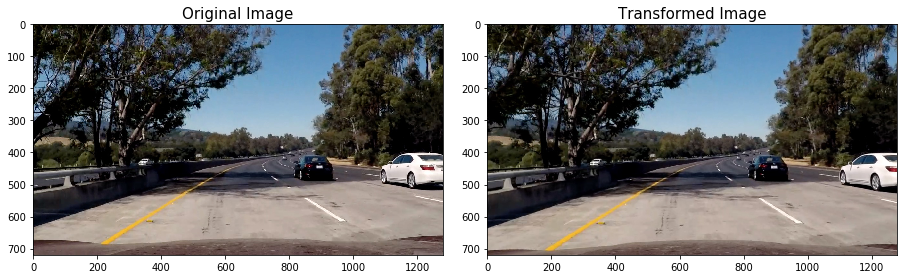

In [11]:
pipeline('Undistorted')

<h3>Sobel_X & Sobel_Y

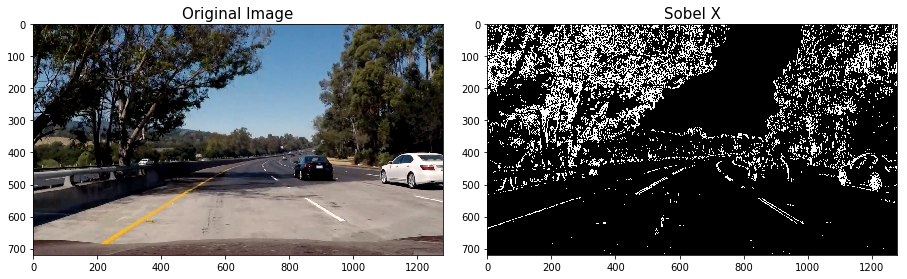

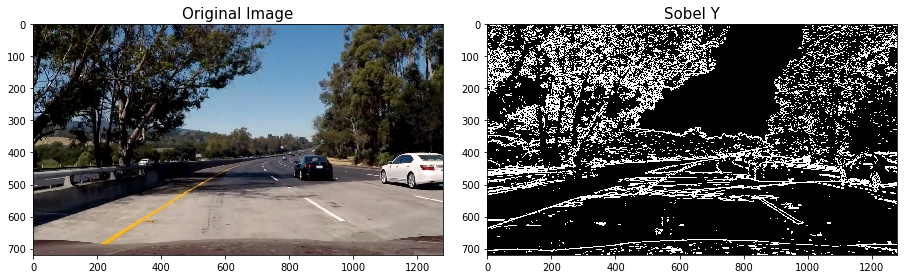

In [13]:
pipeline('Sobel X')
plt.show()
pipeline('Sobel Y')

<h3>Gradient Magnitude

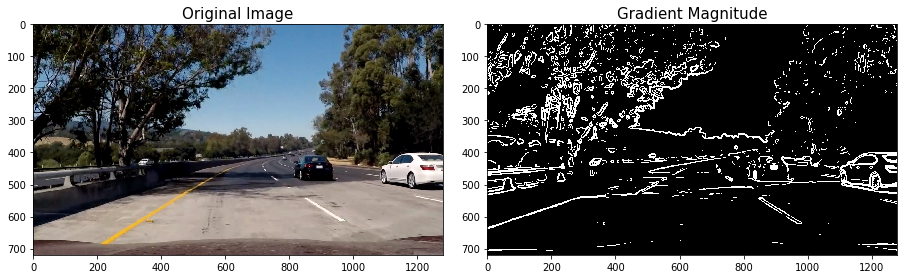

In [15]:
pipeline('Gradient Magnitude')

<h3>Gradient Direction

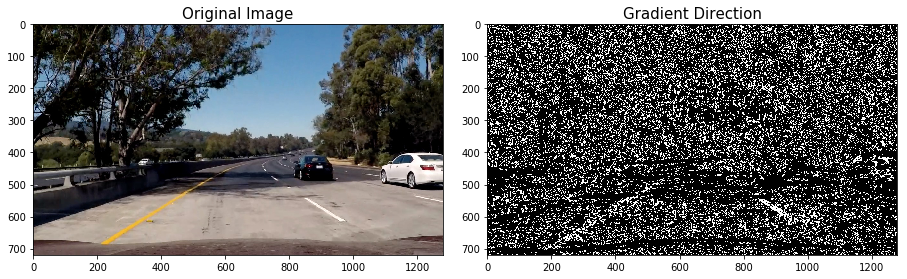

In [17]:
pipeline('Gradient Direction')

<h3>Color Thresholds

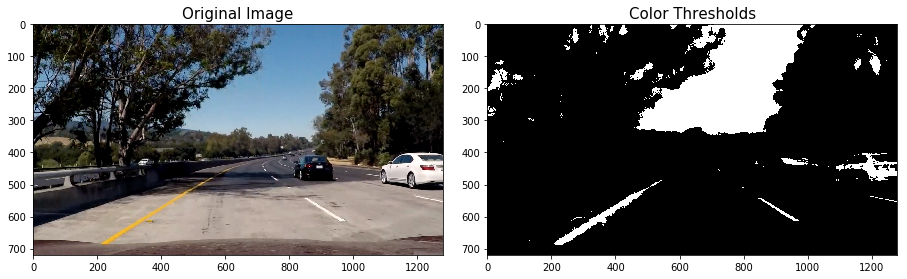

In [18]:
pipeline('Color Thresholds')

<h3>Multi-Thresholded Binary

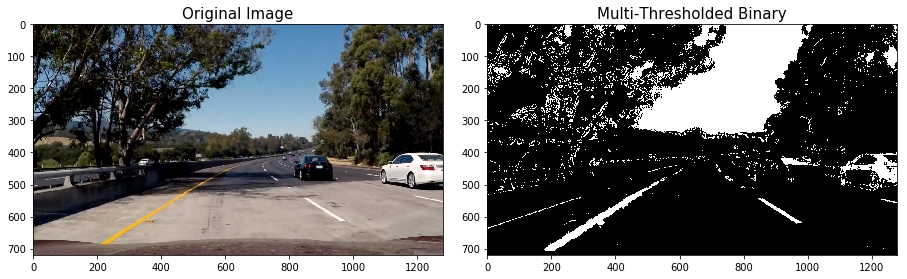

In [19]:
pipeline('Multi-Thresholded Binary')

<h3>Region Masking

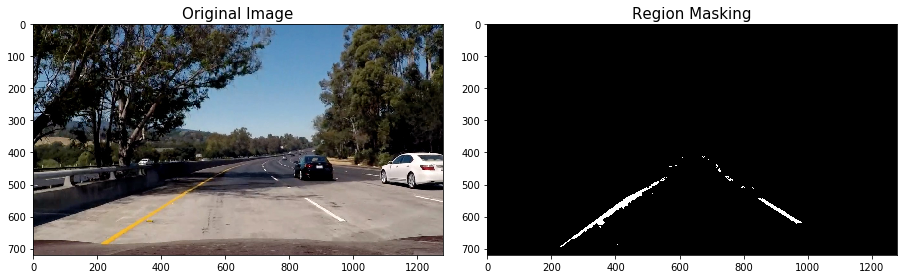

In [20]:
pipeline('Region Masking')

<h3>Perspective Transform

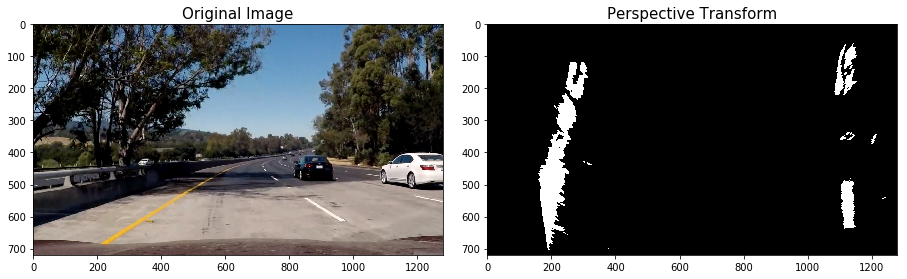

In [21]:
pipeline('Perspective Transform')

<h3>Sliding Windows

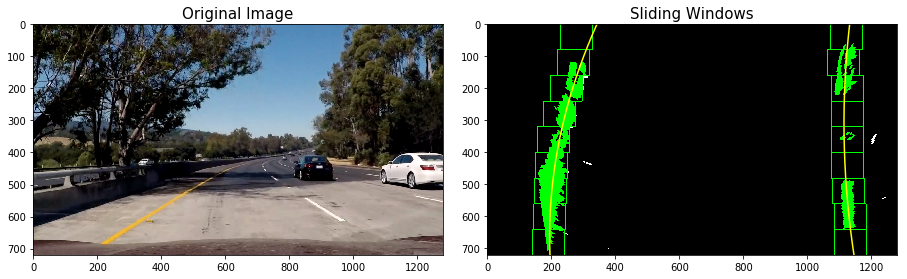

In [24]:
pipeline('Sliding Windows')

<h3>Shaded Lanes

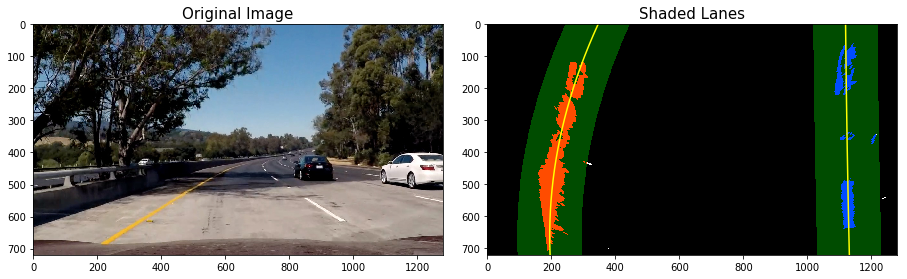

In [22]:
pipeline('Shaded Lanes')

<h3>Lane Mapping

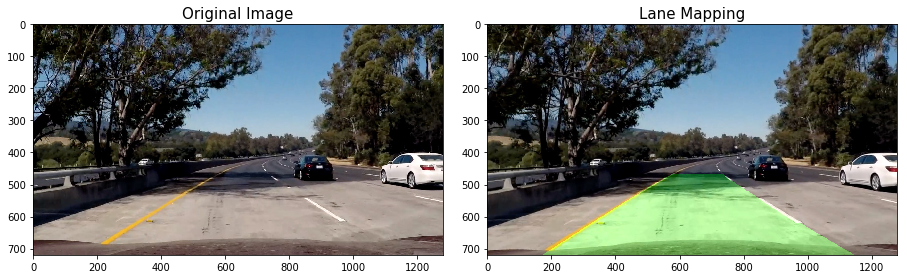

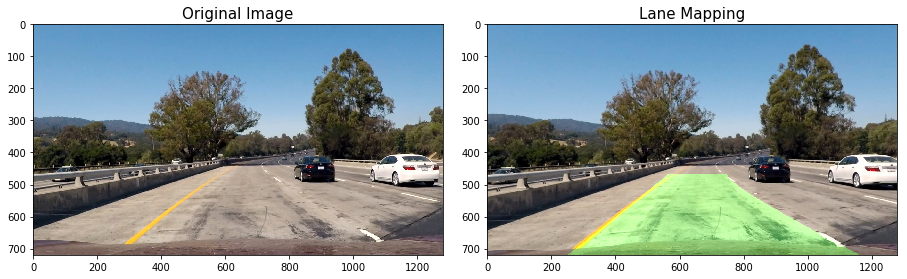

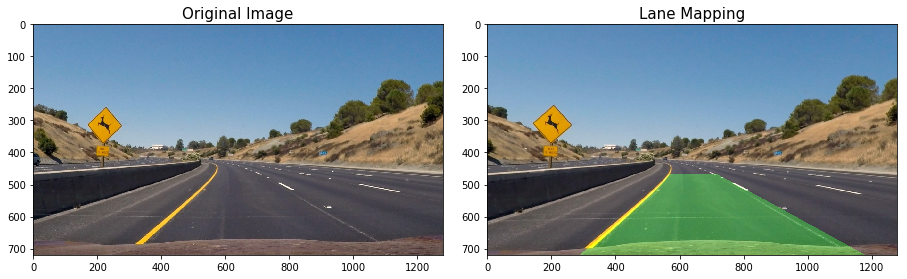

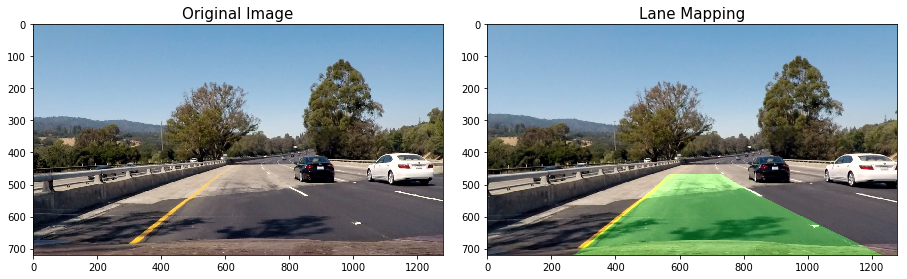

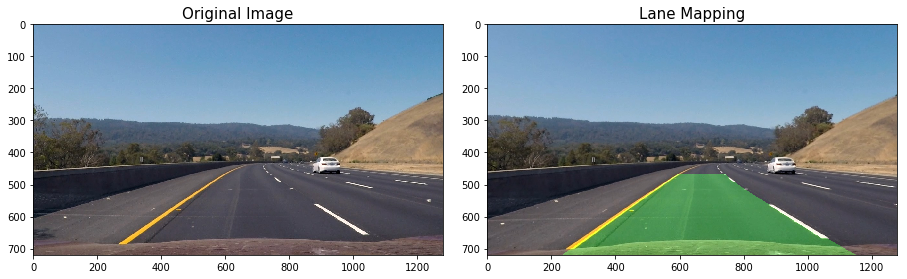

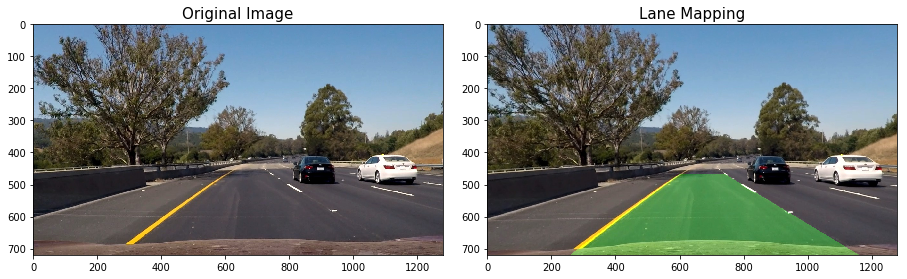

In [23]:
pipeline('Lane Mapping')

<h2>Pipeline for Video Handling

In [25]:
best_fit_test_images = glob.glob('output_images/test*_top_view.jpg')
n_frames = 0

def video_pipeline(img):
    global n_frames
    if n_frames == 0:
        undistorted = undistort(img)
        binary_thresholded = combined_thresholds(undistorted)
        warped, M, Minv = transform_perspective(binary_thresholded)
        windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, rightx, leftx_base, rightx_base = sliding_windows(warped)   
        left_curverad, right_curverad = roc_in_meters(ploty, left_fit, right_fit, leftx, rightx)
        camera = offset(img.shape[1]/2, leftx_base, rightx_base)
        out_img = lane_mapping(img.shape[:2], warped, Minv, ploty, left_fitx, right_fitx, undistorted)
        annotate(out_img, left_curverad, right_curverad, camera)
    else:
        undistorted = undistort(img)
        binary_thresholded = combined_thresholds(undistorted)
        region = region_of_interest(binary_thresholded)
        warped, M, Minv = transform_perspective(region)
        binary_warped = warped
        
        if LEFT.detected == True:
            left_fit = LEFT.current_fit_coeffs
        else:
            left_fit = LEFT.best_fit_coeffs
        
        if RIGHT.detected == True:
            right_fit = RIGHT.current_fit_coeffs
        else:
            right_fit = RIGHT.best_fit_coeffs
        
        windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, rightx, leftx_base, rightx_base = sliding_windows(warped)   

        if LEFT.detected == True:
            LEFT.recent_xfits.append((left_fitx))
            LEFT.best_xfit = np.mean(LEFT.recent_xfits)
            LEFT.current_fit_coeffs.append((left_fit))
            LEFT.best_fit_coeffs = np.mean(LEFT.current_fit_coeffs)
            LEFT.line_base_position = leftx_current
            LEFT.allx = leftx
            LEFT.ally = lefty
        else:
            left_fitx = LEFT.best_xfit
            left_fit = LEFT.best_fit_coeffs
            leftx_current = LEFT.line_base_position
            leftx = LEFT.allx
            lefty = LEFT.ally   
        if RIGHT.detected == True:
            RIGHT.recent_xfits.append((right_fitx))
            RIGHT.best_xfit = np.mean(RIGHT.recent_xfits)
            RIGHT.current_fit_coeffs.append((right_fit))
            RIGHT.best_fit_coeffs = np.mean(RIGHT.current_fit_coeffs)
            RIGHT.line_base_position = rightx_current
            RIGHT.allx = rightx
            RIGHT.ally = righty   
        else:
            right_fitx = RIGHT.best_xfit
            right_fit = RIGHT.best_fit_coeffs
            rightx_current = RIGHT.line_base_position
            rightx = RIGHT.allx
            righty = RIGHT.ally
            
        is_lane_width_correct = verify_lane_width(LEFT.line_base_position, RIGHT.line_base_position)
        if is_lane_width_correct == True:
            LEFT.detected = True
            RIGHT.detected = True
        else:
            LEFT.detected = False
            RIGHT.detected = False
                
        left_curverad, right_curverad =  roc_in_meters(ploty, left_fit, right_fit, leftx, rightx)
        LEFT.radius_of_curvature = left_curverad
        RIGHT.radius_of_curvature = right_curverad
        
        leftx_base = leftx_current
        rightx_base = rightx_current
        camera = offset(img.shape[1]/2, leftx_base, rightx_base, n_frames)
        
        out_img = lane_mapping(img.shape[:2], warped, Minv, ploty, left_fitx, right_fitx, undistorted)
        annotate(out_img, left_curverad, right_curverad, camera)    
    return out_img


/home/sundari/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:261: RankWarning: Polyfit may be poorly conditioned
/home/sundari/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:262: RankWarning: Polyfit may be poorly conditioned


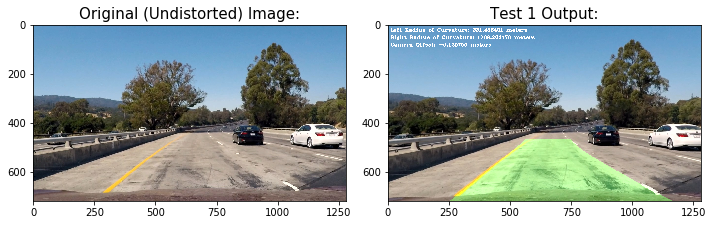

In [26]:
img = cv2.imread('test_images/test1.jpg')
out_img = video_pipeline(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original (Undistorted) Image:', fontsize=15)
ax2.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB), cmap='gray')
ax2.set_title('Test 1 Output:', fontsize=15)


In [ ]:
from moviepy.editor import VideoFileClip

video_output = 'P4_video_final.mp4'
clip = VideoFileClip('project_video.mp4')

output_clip = clip.fl_image(video_pipeline)
%time output_clip.write_videofile(video_output, audio=False)
